<h1>Kickstarter project state prediction</h1>

<h2>Main question</h2>

In this notebook I'll try and find out if it's possible to predict if a project on a crowfunding site, in this case Kickstarter, will be successful or not.

<h2>Inleiding</h2>

There are alot of people in this world that have ambitions and dreams they would like to realize for a multiple of reason, maybe they want to make something groundbreaking as to further technology or create a better standard in a particular field, or perhaps they just want something to make them alot of money. With either of those reasons the people who want to bring that dream to fruition still need money to get started in developing their project.

For this there are crowdfunding sites which allows somebody to show and tell others your project and possibly entice them enough to actually invest in you. Your project won't be fully funded over a nights sleep however so is it possible to know if your project will actually be successful or not before it is actually realized?

<h2>Plan of action</h2>

To predict the state of a project I will be using a dataset directly sourced from the crowdfunding site Kickstarter which contains around 20000 rows of different kickstarter project. The dataset has 60 columns from which I will only use 12 as a majority of them are not exactly useful as a feature.

I predict that the most useful features to accurately predict the state of a project will be the category of the project and the funding goal of the project as both of them have the most sway over a potential investor. To gather the features I will be visualizing my data and try to find if there are anymore features which have the most correlation to my target variable which will be the state. I will also look if the time of year will have a influence on the accuracy.

I will be testing out a bunch of different models to see which will offer the best accuracy and thereafter apply hyperparameter tuning to it.

In [10]:
import sklearn as skl
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import nltk

print("scikit-learn version:", skl.__version__)  # 1.1.3
print("pandas version:", pd.__version__)  # 1.5.1
print("seaborn version:", sb.__version__)  # 0.12.1
print("numpy version:", np.__version__)  # 1.24.5

scikit-learn version: 1.0.2
pandas version: 1.5.2
seaborn version: 0.12.2
numpy version: 1.23.5


In [11]:
## Load in the dataset
df = pd.read_csv("kickstarter_data_with_features.csv", low_memory=False)

## Create a new
df = df[["id", "name", "blurb", "goal", "pledged", "state", "country", "deadline", "created_at", "launched_at",
         "backers_count", "category"]]

df

,id,name,blurb,goal,pledged,state,country,deadline,created_at,launched_at,backers_count,category
0,1454391034,Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,0.0,failed,US,2015-01-23 10:35:00,2014-11-29 22:55:57,2014-12-17 13:47:36,0,Academic
1,1655206086,Jump Start Kindergarten Toolkit,"This kit teaches how to print, correct an ugly...",500.0,0.0,failed,US,2015-05-01 16:13:22,2015-02-20 09:28:43,2015-03-02 16:13:22,0,Academic
2,311581827,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,"Establishing a free, world-class, public libra...",100000.0,120.0,failed,US,2015-03-26 08:17:04,2015-01-24 00:08:06,2015-01-25 08:17:04,5,Academic
3,859724515,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",Goal: Introducing a new word into the English ...,5000.0,0.0,failed,US,2014-10-06 00:41:17,2014-09-05 22:30:00,2014-09-06 00:41:17,0,Academic
4,1613604977,"Synopse der EU-DSGVO - Artikel, Erwägungsgründ...",Zu den Artikeln der DSGVO sind die korrespondi...,3222.0,356.0,failed,DE,2016-06-27 12:00:00,2016-05-25 14:09:49,2016-05-26 05:57:27,17,Academic
...,...,...,...,...,...,...,...,...,...,...,...,...
20627,2118633700,"StorySnap: Your voice, their stories... in a s...",The easy way to be present for story time anyt...,32500.0,25868.0,failed,CH,2016-01-10 16:59:00,2015-12-04 03:44:29,2015-12-09 17:11:19,173,Apps
20628,657198274,Smart Fit!,A revolutionary App that makes getting fit as ...,100000.0,1559.0,failed,DE,2017-01-05 11:41:36,2016-10-11 09:16:52,2016-12-06 11:41:36,13,Apps
20629,1790340460,Sloth Face App,"We all love fatbooth and Ugly booth, why not s...",10000.0,0.0,failed,US,2015-04-14 12:08:00,2015-02-12 12:11:28,2015-02-13 12:08:00,0,Apps
20630,2028578264,DriverTools,Production android app for cab drivers and tru...,2500.0,0.0,failed,US,2015-05-20 13:36:59,2015-04-18 20:26:42,2015-04-20 13:36:59,0,Apps


<h1> Data cleaning </h1>

In [12]:
## Check if there are any NaN values
df.isnull().sum()

id                  0
name                0
blurb               5
goal                0
pledged             0
state               0
country             0
deadline            0
created_at          0
launched_at         0
backers_count       0
category         1889
dtype: int64

In [13]:
df['category'].unique()

array(['Academic', 'Places', nan, 'Blues', 'Restaurants', 'Webseries',
       'Thrillers', 'Shorts', 'Web', 'Apps', 'Gadgets', 'Hardware',
       'Festivals', 'Plays', 'Musical', 'Flight', 'Spaces', 'Immersive',
       'Experimental', 'Comedy', 'Wearables', 'Sound', 'Software',
       'Robots', 'Makerspaces'], dtype=object)

In [14]:
df = df.dropna(subset=['blurb'])

train_df = df.dropna(subset=['category'])
test_df = df[df['category'].isnull()]

X_train = train_df['blurb'].values.astype('U')
y_train = train_df['category']

In [15]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)

n_topics = 10
nmf = NMF(n_components=n_topics, random_state=42)
X_train_topics = nmf.fit_transform(X_train_tfidf)

C:\Users\wvanb\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [16]:
# Initialize the multi-label classifier
classifier = MultiOutputClassifier(RandomForestClassifier())

y_train_reshaped = y_train.values.reshape(-1, 1)

# Train the model
classifier.fit(X_train_topics, y_train_reshaped)

MultiOutputClassifier(estimator=RandomForestClassifier())

In [17]:
# Extract 'blurb' column from the test set
X_test = test_df['blurb']

# Convert 'blurb' text into numerical features using the same vectorizer
X_test_tfidf = vectorizer.transform(X_test)

# Perform topic modeling on the test set
X_test_topics = nmf.transform(X_test_tfidf)

# Make predictions on the test set
predicted_categories = classifier.predict(X_test_topics)

np.unique(predicted_categories)

array(['Apps', 'Experimental', 'Festivals', 'Gadgets', 'Hardware',
       'Immersive', 'Makerspaces', 'Musical', 'Places', 'Plays', 'Robots',
       'Shorts', 'Software', 'Sound', 'Spaces', 'Wearables', 'Web'],
      dtype=object)

In [18]:
# Update the missing 'category' values in the original dataset
df.loc[df['category'].isnull(), 'category'] = predicted_categories

# Save the updated dataset to the same CSV file
df.to_csv('kickstarter_data_with_features', index=False)

df

,id,name,blurb,goal,pledged,state,country,deadline,created_at,launched_at,backers_count,category
0,1454391034,Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,0.0,failed,US,2015-01-23 10:35:00,2014-11-29 22:55:57,2014-12-17 13:47:36,0,Academic
1,1655206086,Jump Start Kindergarten Toolkit,"This kit teaches how to print, correct an ugly...",500.0,0.0,failed,US,2015-05-01 16:13:22,2015-02-20 09:28:43,2015-03-02 16:13:22,0,Academic
2,311581827,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,"Establishing a free, world-class, public libra...",100000.0,120.0,failed,US,2015-03-26 08:17:04,2015-01-24 00:08:06,2015-01-25 08:17:04,5,Academic
3,859724515,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",Goal: Introducing a new word into the English ...,5000.0,0.0,failed,US,2014-10-06 00:41:17,2014-09-05 22:30:00,2014-09-06 00:41:17,0,Academic
4,1613604977,"Synopse der EU-DSGVO - Artikel, Erwägungsgründ...",Zu den Artikeln der DSGVO sind die korrespondi...,3222.0,356.0,failed,DE,2016-06-27 12:00:00,2016-05-25 14:09:49,2016-05-26 05:57:27,17,Academic
...,...,...,...,...,...,...,...,...,...,...,...,...
20627,2118633700,"StorySnap: Your voice, their stories... in a s...",The easy way to be present for story time anyt...,32500.0,25868.0,failed,CH,2016-01-10 16:59:00,2015-12-04 03:44:29,2015-12-09 17:11:19,173,Apps
20628,657198274,Smart Fit!,A revolutionary App that makes getting fit as ...,100000.0,1559.0,failed,DE,2017-01-05 11:41:36,2016-10-11 09:16:52,2016-12-06 11:41:36,13,Apps
20629,1790340460,Sloth Face App,"We all love fatbooth and Ugly booth, why not s...",10000.0,0.0,failed,US,2015-04-14 12:08:00,2015-02-12 12:11:28,2015-02-13 12:08:00,0,Apps
20630,2028578264,DriverTools,Production android app for cab drivers and tru...,2500.0,0.0,failed,US,2015-05-20 13:36:59,2015-04-18 20:26:42,2015-04-20 13:36:59,0,Apps


In [19]:
df.isnull().sum()

id               0
name             0
blurb            0
goal             0
pledged          0
state            0
country          0
deadline         0
created_at       0
launched_at      0
backers_count    0
category         0
dtype: int64

<h1> Data vizualization </h1>

Now I'll start with actually visualizing my data starting with visualizing the distribution of categories between failed and successful projects.

<AxesSubplot: title={'center': 'state distribution'}>

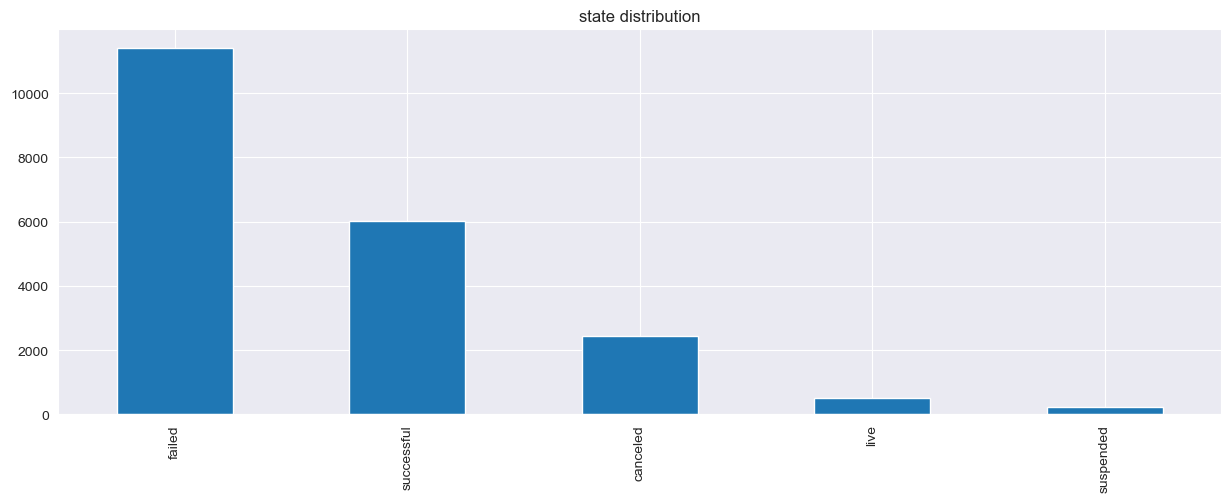

In [20]:
fig = df["state"].value_counts().plot(kind="bar", title="state distribution", figsize=(15, 5))

fig

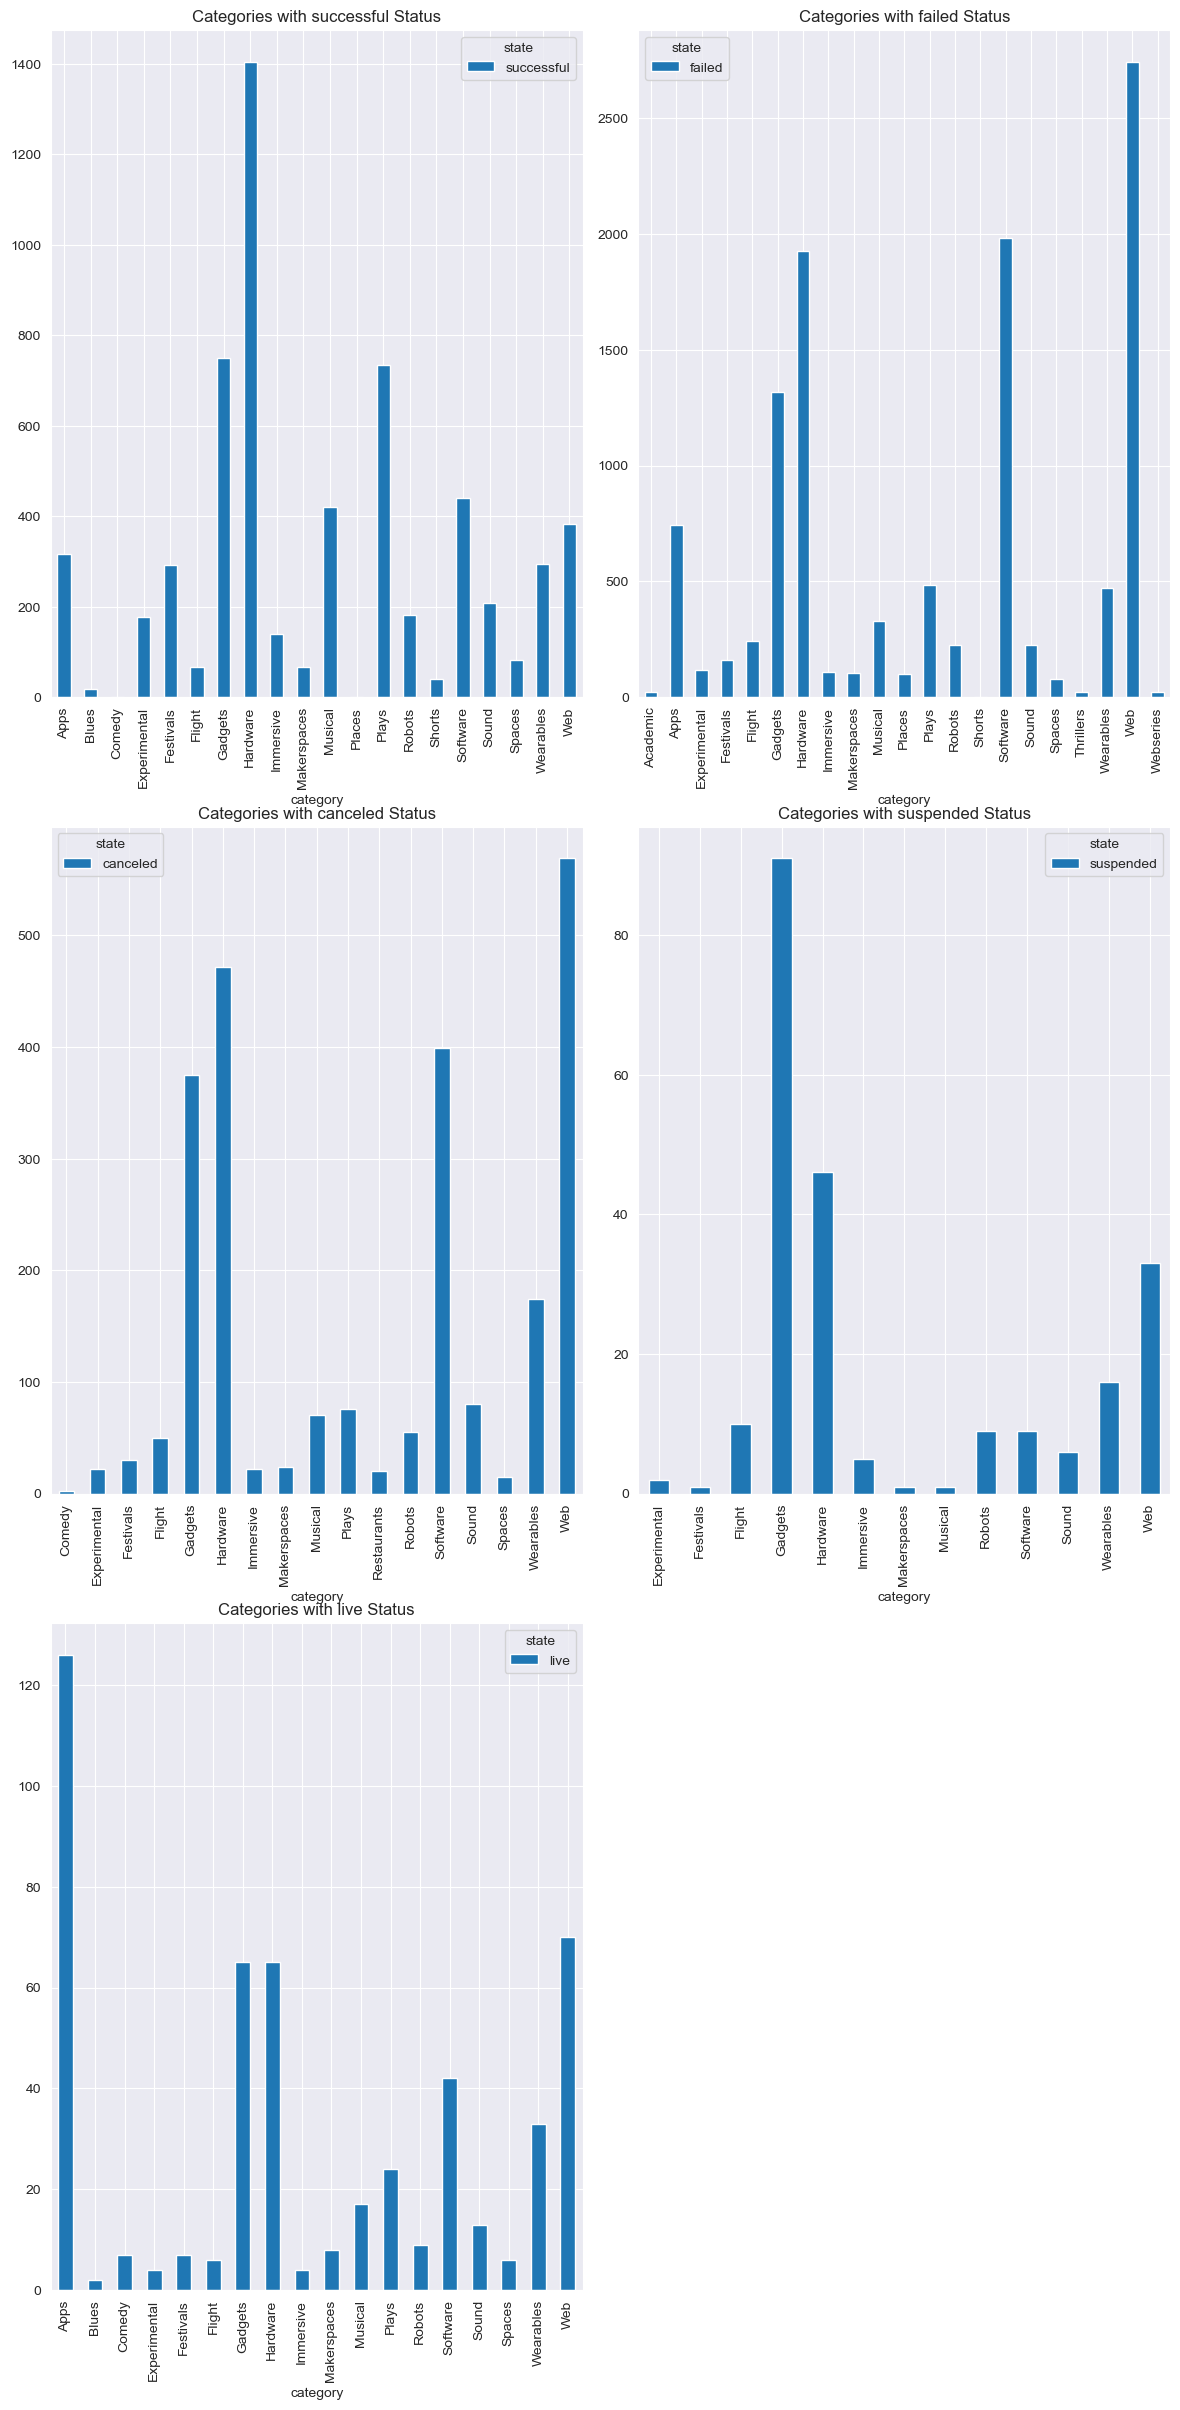

In [21]:
failed_data = df[df['state'] == 'failed']

grouped_failed_data = failed_data.groupby('category')['state'].value_counts().unstack(fill_value=0)

successful_data = df[df['state'] == 'successful']

grouped_successful_data = successful_data.groupby('category')['state'].value_counts().unstack(fill_value=0)

canceled_data = df[df['state'] == 'canceled']

grouped_cancelled_data = canceled_data.groupby('category')['state'].value_counts().unstack(fill_value=0)

live_data = df[df['state'] == 'live']

grouped_live_data = live_data.groupby('category')['state'].value_counts().unstack(fill_value=0)

suspended_data = df[df['state'] == 'suspended']

grouped_suspended_data = suspended_data.groupby('category')['state'].value_counts().unstack(fill_value=0)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 24))

grouped_successful_data.plot(kind='bar', ax=axes[0, 0])
grouped_failed_data.plot(kind='bar', ax=axes[0, 1])
grouped_cancelled_data.plot(kind='bar', ax=axes[1, 0])
grouped_suspended_data.plot(kind='bar', ax=axes[1, 1])
grouped_live_data.plot(kind='bar', ax=axes[2, 0])
plt.tight_layout()

axes[0, 0].set_title('Categories with successful Status')
axes[0, 1].set_title('Categories with failed Status')
axes[1, 0].set_title('Categories with canceled Status')
axes[1, 1].set_title('Categories with suspended Status')
axes[2, 0].set_title('Categories with live Status')

fig.delaxes(axes[2, 1])

plt.show()

<h1>Sentiment analysis</h1>

In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize

sentences = df["blurb"]

sentiment_counts = {"positive": 0, "negative": 0, "neutral": 0}

tokenized_sentences = [word_tokenize(sentence) for sentence in sent_tokenize(" ".join(sentences))]

sid = SentimentIntensityAnalyzer()

sentiment_results = []
for sentence in tokenized_sentences:
    text = " ".join(sentence)
    scores = sid.polarity_scores(text)
    sentiment_results.append(scores)

for i, sentence in enumerate(sentences):
    sentiment = "positive" if sentiment_results[i]['compound'] > 0 else "negative" if sentiment_results[i][
                                                                                          'compound'] < 0 else "neutral"

    sentiment_counts[sentiment] += 1

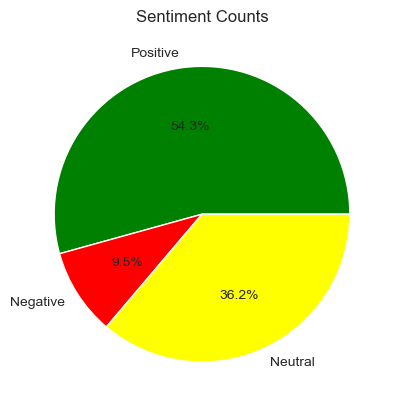

In [23]:
labels = ["Positive", "Negative", "Neutral"]
values = [sentiment_counts["positive"], sentiment_counts["negative"], sentiment_counts["neutral"]]
colors = ["green", "red", "yellow"]
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%')

plt.title("Sentiment Counts")

plt.show()

It seems that a large amount of the sentiment scores are neutral which is rather odd since in this context the descriptions are meant to incentivize people to fund their projects. I expected almost all the sentiment scores to be positive. There a couple possible explanations as to why the scores are neutral one of which would be that the vader sentiment tool is not properly trained to work on product descriptions which means the words it has in it is dictionary might be perceived in a more negative or positive light than it's intended meaning from the product owners.

I might have been able to change the hyperparameter so that the sentiment tool would offer a different result, unfortunately however the vader sentiment tool doesn't have a hyperparameter that I can tune. I will try a different sentiment analysis tool to see if I could get a different result that would align more with my expectations.

In [24]:
from textblob import TextBlob

textBlob_counts = {"positive": 0, "negative": 0, "neutral": 0}

for texts in sentences:
    blob = TextBlob(texts)
    sentiment_score = blob.sentiment.polarity

    sentiment_textBlob = "positive" if sentiment_score > 0 else "negative" if sentiment_score < 0 else "neutral"

    textBlob_counts[sentiment_textBlob] += 1

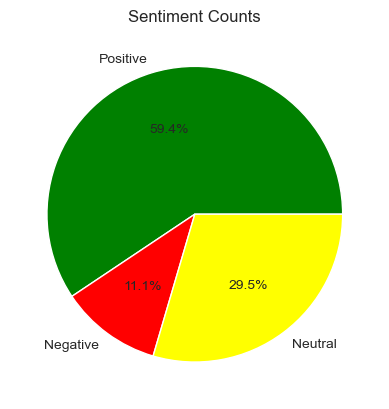

In [25]:
labels = ["Positive", "Negative", "Neutral"]
values = [textBlob_counts["positive"], textBlob_counts["negative"], textBlob_counts["neutral"]]
colors = ["green", "red", "yellow"]
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%')

plt.title("Sentiment Counts")

plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])
df['state'] = le.fit_transform(df['state'])

X_train, X_test, y_train, y_test = train_test_split(df[['goal', 'category']], df['state'], test_size=0.2,
                                                    random_state=42)

<h1>Logistic Regression model</h1>

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

clfLogistic = LogisticRegression(max_iter=1000)
clfLogistic.fit(X_train, y_train)

y_pred = clfLogistic.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

C:\Users\wvanb\AppData\Local\Temp\ipykernel_17080\341252801.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = le.fit_transform(df['category'])
C:\Users\wvanb\AppData\Local\Temp\ipykernel_17080\341252801.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = le.fit_transform(df['state'])


Accuracy: 0.5508967523024721
Confusion matrix:
[[   0  485    0    0    0]
 [   0 2273    0    0    0]
 [   0   98    0    0    0]
 [   0 1224    0    0    0]
 [   0   46    0    0    0]]


<h1>Gradient boosting model</h1>

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

# Train a gradient boosting model
clfGradient = GradientBoostingClassifier(learning_rate=0.029576955482703147, n_estimators=500, max_depth=3, min_samples_split=6, min_samples_leaf=9)

clfGradient.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clfGradient.predict(X_test)

# Calculate the accuracy score
print('Accuracy:', accuracy_score(y_test, y_pred))

# Calculate the confusion matrix
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.605913717886573
Confusion matrix:
[[   4  429    1   51    0]
 [   0 1981    0  292    0]
 [   0   82    0   16    0]
 [   0  705    0  515    4]
 [   0   39    0    7    0]]


<h1>SVC model</h1>

In [28]:
from sklearn.svm import SVC

# Train an SVM model
clfSVC = SVC()
clfSVC.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clfSVC.predict(X_test)

# Calculate the accuracy score
print('Accuracy:', accuracy_score(y_test, y_pred))

# Calculate the confusion matrix
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5511391177896268
Confusion matrix:
[[   1  484    0    0    0]
 [   0 2273    0    0    0]
 [   0   98    0    0    0]
 [   0 1224    0    0    0]
 [   0   46    0    0    0]]


<h1>Random Forest Classifier</h1>

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Train a random forest model
clfRandom = RandomForestClassifier(n_jobs=1, n_estimators=500)

clfRandom.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clfRandom.predict(X_test)

# Calculate the accuracy score
print('Accuracy:', accuracy_score(y_test, y_pred))

# Calculate the confusion matrix
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

<h1> Decision tree classifier</h1>

In [30]:
from sklearn.tree import DecisionTreeClassifier

# Train a decision tree model
clfDescision = DecisionTreeClassifier()
clfDescision.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clfDescision.predict(X_test)

# Calculate the accuracy score
print('Accuracy:', accuracy_score(y_test, y_pred))

# Calculate the confusion matrix
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5744062045564712
Confusion matrix:
[[  33  387    3   61    1]
 [  86 1858    8  320    1]
 [   3   77    1   17    0]
 [  32  702    8  478    4]
 [   2   39    1    4    0]]


<h1> Hyperparameter Tuning</h1>

From all the models GradientBoosting seems to be the most effective at predicting so I'll be running a randomized search and grid search to look for the best hyper paramater options so the model will get a better result

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import optuna

def objective(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    clf = GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-05-23 18:56:19,120] A new study created in memory with name: no-name-d8dff943-0b1c-45f8-895e-88e830b889e3
[I 2023-05-23 18:57:46,106] Trial 0 finished with value: 0.5775569558894813 and parameters: {'learning_rate': 0.10778473163734907, 'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5775569558894813.
[I 2023-05-23 18:58:18,106] Trial 1 finished with value: 0.5870092098885119 and parameters: {'learning_rate': 0.10415373952549459, 'n_estimators': 700, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.5870092098885119.
[I 2023-05-23 18:58:43,895] Trial 2 finished with value: 0.5925836160930683 and parameters: {'learning_rate': 0.1757628189352971, 'n_estimators': 800, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.5925836160930683.
[I 2023-05-23 18:58:51,650] Trial 3 finished with value: 0.5986427532719341 and parameters: 

Best Hyperparameters: {'learning_rate': 0.0303198458820301, 'n_estimators': 500, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 9}
Best Accuracy: 0.6066408143480368
